# Detecting Human Activities Through Smartphone Sensor - Training

## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob
from tqdm import tqdm
import seaborn as sns
import filecmp
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import warnings
from sklearn.linear_model import LogisticRegression
import pydot
from IPython.display import Image
from mlxtend import plotting
from six import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

## Global Variables

In [2]:
PBAR_FORMAT='{desc:12}{percentage:3.0f}%|{bar:27}[ {n:4d}/{total:4d}, {elapsed}<{remaining}{postfix} ]'

ACTIVITY_CODES_MAP = {'A': 'walking',
                          'B': 'jogging',
                          'C': 'stairs',
                          'D': 'sitting',
                          'E': 'standing',
                          'F': 'typing',
                          'G': 'brushing teeth',
                          'H': 'eating soup',
                          'I': 'eating chips',
                          'J': 'eating pasta',
                          'K': 'drinking from cup',
                          'L': 'eating sandwich',
                          'M': 'kicking soccer ball',
                          'O': 'playing catch tennis ball',
                          'P': 'dribbling basket ball',
                          'Q': 'writing',
                          'R': 'clapping',
                          'S': 'folding clothes'}

ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "typing", "brushing teeth",
                  "eating soup", "eating chips", "eating pasta", "drinking from cup", "eating sandwich",
                  "kicking soccer ball", "playing catch tennis ball", "dribbling basket ball",
                  "writing", "clapping", "folding clothes"]

# csv file column names
COL_NAMES =  ['id' , 'activity_code' , 'timestamp', 'x', 'y', 'z']
# training verbose
VERBOSE = 1
# rnadom state for split
RANDOM_STATE=12345

## Extracted Features

In [3]:
EXTRACTED_FEATURES = ['ACTIVITY',
                        'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
                        'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9',
                        'Z0', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9',
                        'XAVG', 'YAVG', 'ZAVG',
                        'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV',
                        'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV',
                        'XVAR', 'YVAR', 'ZVAR',
                        'XMFCC0', 'XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4',
                        'XMFCC5', 'XMFCC6', 'XMFCC7',
                        'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11', 'XMFCC12',
                        'YMFCC0', 'YMFCC1', 'YMFCC2', 'YMFCC3', 'YMFCC4',
                        'YMFCC5', 'YMFCC6', 'YMFCC7',
                        'YMFCC8', 'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12',
                        'ZMFCC0', 'ZMFCC1', 'ZMFCC2', 'ZMFCC3', 'ZMFCC4',
                        'ZMFCC5', 'ZMFCC6', 'ZMFCC7',
                        'ZMFCC8', 'ZMFCC9', 'ZMFCC10', 'ZMFCC11', 'ZMFCC12',
                        'XYCOS', 'XZCOS', 'YZCOS',
                        'XYCOR', 'XZCOR', 'YZCOR',
                        'RESULTANT',
                        'PARTICIPANT'] # Categirical: 1600 -1650

len(EXTRACTED_FEATURES)


90

## Dataset

In [4]:
def WISDM_Dataset(DATA_DIR):
    all_files = glob.glob(DATA_DIR + "/*.txt")

    list_dfs = []
    for filename in all_files:
        df = pd.read_csv(filename, names = EXTRACTED_FEATURES, index_col=None, header=0)
        list_dfs.append(df)

    all_data = pd.concat(list_dfs, axis=0, ignore_index=True, sort=False)

    return all_data

## Training on Watch - Accelerometer

### Hyper parameters

In [5]:
NUM_SPLITS=5
TRAIN_SIZE=0.8
TEST_SIZE=1-TRAIN_SIZE

my_param_grid = {'C': [10, 50, 100, 200]}
DATA_DIR="../dataset/processed/watch/accel"

### Initialize Dataset

In [6]:
all_watch_accel = WISDM_Dataset(DATA_DIR)

# The approach in this analysis will be to see all the participants as a single, unified group.
# The aim of this analysis is not to examine differences between participants.
all_watch_accel.drop('PARTICIPANT', axis = 1, inplace = True)

y = all_watch_accel.ACTIVITY
X = all_watch_accel.drop('ACTIVITY', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = TRAIN_SIZE,
                                                    test_size = TEST_SIZE,
                                                    shuffle = True,
                                                    stratify = y)

# Temporarily re-unite the train lables to train dataset for further preprocessing steps.
X_train.insert(0, 'Y', y_train)

# separating y_train
y_train = X_train['Y']
X_train.drop(['Y'], axis = 1, inplace = True)

# rescaling is applied to the features that their absolute values exceed the range of ~1
rescalin_features=['XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']
scaling_transformer = MaxAbsScaler().fit(X_train[rescalin_features])
X_train[rescalin_features] = scaling_transformer.transform(X_train[rescalin_features])

X_test = X_test.copy()
X_test[rescalin_features] = scaling_transformer.transform(X_test[rescalin_features])

# resetting the indices
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [7]:
X_train.columns

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'Y0', 'Y1',
       'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1', 'Z2', 'Z3',
       'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV',
       'YABSOLDEV', 'ZABSOLDEV', 'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR',
       'YVAR', 'ZVAR', 'XMFCC0', 'XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4',
       'XMFCC5', 'XMFCC6', 'XMFCC7', 'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11',
       'XMFCC12', 'YMFCC0', 'YMFCC1', 'YMFCC2', 'YMFCC3', 'YMFCC4', 'YMFCC5',
       'YMFCC6', 'YMFCC7', 'YMFCC8', 'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12',
       'ZMFCC0', 'ZMFCC1', 'ZMFCC2', 'ZMFCC3', 'ZMFCC4', 'ZMFCC5', 'ZMFCC6',
       'ZMFCC7', 'ZMFCC8', 'ZMFCC9', 'ZMFCC10', 'ZMFCC11', 'ZMFCC12', 'XYCOS',
       'XZCOS', 'YZCOS', 'XYCOR', 'XZCOR', 'YZCOR', 'RESULTANT'],
      dtype='object')

### Training

In [8]:
my_cv = StratifiedShuffleSplit(n_splits=NUM_SPLITS,
                               train_size=TRAIN_SIZE,
                               test_size=TEST_SIZE)

lr_classifier = LogisticRegression(verbose = 0, solver='liblinear')
lr_model_gs = GridSearchCV(estimator=lr_classifier,
                           param_grid=my_param_grid,
                           cv=my_cv,
                           scoring = 'accuracy')
lr_model_gs.fit(X_train, y_train)
lr_best_classifier = lr_model_gs.best_estimator_
print(lr_model_gs.best_params_)
print(lr_model_gs.cv_results_)
print(lr_best_classifier.get_params())

{'C': 200}
{'mean_fit_time': array([ 9.15668025, 12.50984321, 14.24838042, 15.64534426]), 'std_fit_time': array([0.24585661, 0.16405369, 0.38052986, 0.42320842]), 'mean_score_time': array([0.00881481, 0.00864859, 0.00863552, 0.0086997 ]), 'std_score_time': array([2.61226001e-04, 6.59962954e-05, 2.71064205e-05, 4.46156019e-05]), 'param_C': masked_array(data=[10, 50, 100, 200],
             mask=[False, False, False, False],
       fill_value=999999), 'params': [{'C': 10}, {'C': 50}, {'C': 100}, {'C': 200}], 'split0_test_score': array([0.70432802, 0.71070615, 0.71161731, 0.71298405]), 'split1_test_score': array([0.71799544, 0.72756264, 0.72892938, 0.73166287]), 'split2_test_score': array([0.71070615, 0.723918  , 0.71981777, 0.71936219]), 'split3_test_score': array([0.71207289, 0.72528474, 0.72756264, 0.72528474]), 'split4_test_score': array([0.70569476, 0.72346241, 0.72528474, 0.72984055]), 'mean_test_score': array([0.71015945, 0.72218679, 0.72264237, 0.72382688]), 'std_test_score': arra

### Evaluation

#### Train Accuracy

In [9]:
scores = cross_val_score(lr_best_classifier, X_train, y_train, cv=my_cv, scoring='accuracy')
print(list(scores))

lr_best_classifier.score(X_train, y_train)
y_train_pred = lr_best_classifier.predict(X_train)

print("######################################################################################")
print("train accuracy:", 100 * accuracy_score(y_true=y_train, y_pred=y_train_pred))
print("######################################################################################")

[0.730751708428246, 0.7220956719817767, 0.7312072892938497, 0.7298405466970387, 0.7275626423690205]
######################################################################################
train accuracy: 75.33485193621868
######################################################################################


#### Confusion Matrix

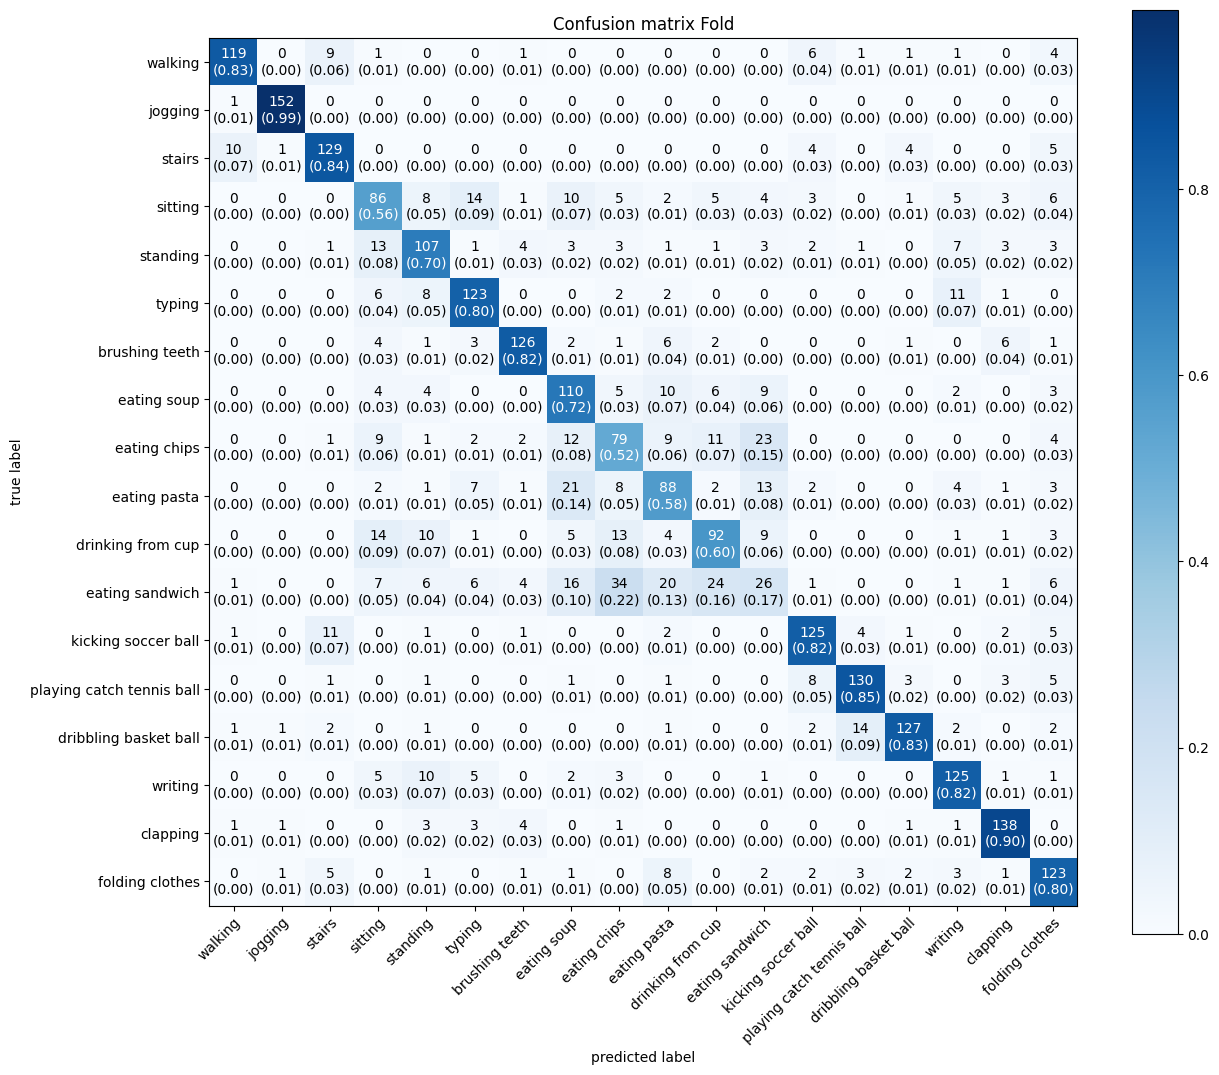

In [10]:
y_test_pred = lr_best_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
plotting.plot_confusion_matrix(conf_mat = conf_matrix,
                               class_names = ACTIVITY_NAMES,
                               show_normed = True,
                               figsize = (14, 12),
                               colorbar = True)
plt.title("Confusion matrix Fold")
plt.show()

#### Accuracy Per Activity

In [11]:
cm_act = pd.DataFrame(conf_matrix,
                      index=lr_best_classifier.classes_,
                      columns=lr_best_classifier.classes_)

cm_act.columns = ACTIVITY_CODES_MAP.values()
cm_act.index = ACTIVITY_CODES_MAP.values()
accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())
print(accuracy_per_activity)

                                  0
walking                    0.832168
jogging                    0.993464
stairs                     0.843137
sitting                    0.562092
standing                   0.699346
typing                     0.803922
brushing teeth             0.823529
eating soup                0.718954
eating chips               0.516340
eating pasta               0.575163
drinking from cup          0.601307
eating sandwich            0.169935
kicking soccer ball        0.816993
playing catch tennis ball  0.849673
dribbling basket ball      0.830065
writing                    0.816993
clapping                   0.901961
folding clothes            0.803922


/tmp/ipykernel_2398630/2628092090.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())


#### Classification Report

In [12]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred))
print("######################################################################################")

              precision    recall  f1-score   support

           A       0.89      0.83      0.86       143
           B       0.97      0.99      0.98       153
           C       0.81      0.84      0.83       153
           D       0.57      0.56      0.57       153
           E       0.66      0.70      0.68       153
           F       0.75      0.80      0.77       153
           G       0.87      0.82      0.85       153
           H       0.60      0.72      0.65       153
           I       0.51      0.52      0.51       153
           J       0.57      0.58      0.57       153
           K       0.64      0.60      0.62       153
           L       0.29      0.17      0.21       153
           M       0.81      0.82      0.81       153
           O       0.85      0.85      0.85       153
           P       0.90      0.83      0.86       153
           Q       0.77      0.82      0.79       153
           R       0.86      0.90      0.88       153
           S       0.71    

#### Test Accuracy

In [13]:
print("test accuracy", 100 * accuracy_score(y_true=y_test, y_pred=y_test_pred))

test accuracy 73.06851311953353


## Training on Watch - Gyroscope

### Hyper parameters

In [14]:
NUM_SPLITS=5
TRAIN_SIZE=0.8
TEST_SIZE=1-TRAIN_SIZE

my_param_grid = {'C': [10, 50, 100, 200]}
DATA_DIR="../dataset/processed/watch/gyro"

### Initialize Dataset

In [15]:
all_watch_gyro = WISDM_Dataset(DATA_DIR)

# The approach in this analysis will be to see all the participants as a single, unified group.
# The aim of this analysis is not to examine differences between participants.
all_watch_gyro.drop('PARTICIPANT', axis = 1, inplace = True)

y = all_watch_gyro.ACTIVITY
X = all_watch_gyro.drop('ACTIVITY', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = TRAIN_SIZE,
                                                    test_size = TEST_SIZE,
                                                    shuffle = True,
                                                    stratify = y)

# Temporarily re-unite the train lables to train dataset for further preprocessing steps.
X_train.insert(0, 'Y', y_train)

# separating y_train
y_train = X_train['Y']
X_train.drop(['Y'], axis = 1, inplace = True)

# rescaling is applied to the features that their absolute values exceed the range of ~1
rescalin_features=['XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']
scaling_transformer = MaxAbsScaler().fit(X_train[rescalin_features])
X_train[rescalin_features] = scaling_transformer.transform(X_train[rescalin_features])

X_test = X_test.copy()
X_test[rescalin_features] = scaling_transformer.transform(X_test[rescalin_features])

# resetting the indices
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [16]:
X_train.columns

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'Y0', 'Y1',
       'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1', 'Z2', 'Z3',
       'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV',
       'YABSOLDEV', 'ZABSOLDEV', 'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR',
       'YVAR', 'ZVAR', 'XMFCC0', 'XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4',
       'XMFCC5', 'XMFCC6', 'XMFCC7', 'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11',
       'XMFCC12', 'YMFCC0', 'YMFCC1', 'YMFCC2', 'YMFCC3', 'YMFCC4', 'YMFCC5',
       'YMFCC6', 'YMFCC7', 'YMFCC8', 'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12',
       'ZMFCC0', 'ZMFCC1', 'ZMFCC2', 'ZMFCC3', 'ZMFCC4', 'ZMFCC5', 'ZMFCC6',
       'ZMFCC7', 'ZMFCC8', 'ZMFCC9', 'ZMFCC10', 'ZMFCC11', 'ZMFCC12', 'XYCOS',
       'XZCOS', 'YZCOS', 'XYCOR', 'XZCOR', 'YZCOR', 'RESULTANT'],
      dtype='object')

### Training

In [17]:
my_cv = StratifiedShuffleSplit(n_splits=NUM_SPLITS,
                               train_size=TRAIN_SIZE,
                               test_size=TEST_SIZE)

lr_classifier = LogisticRegression(verbose = 0, solver='liblinear')
lr_model_gs = GridSearchCV(estimator=lr_classifier,
                           param_grid=my_param_grid,
                           cv=my_cv,
                           scoring = 'accuracy')
lr_model_gs.fit(X_train, y_train)
lr_best_classifier = lr_model_gs.best_estimator_
print(lr_model_gs.best_params_)
print(lr_model_gs.cv_results_)
print(lr_best_classifier.get_params())

{'C': 200}
{'mean_fit_time': array([ 6.75775394,  9.87976608, 11.45579906, 12.74188385]), 'std_fit_time': array([0.14889785, 0.15803457, 0.15161424, 0.26370624]), 'mean_score_time': array([0.00868769, 0.00872202, 0.00867543, 0.00868211]), 'std_score_time': array([8.15326565e-05, 6.68687230e-05, 4.60612354e-05, 1.38257583e-04]), 'param_C': masked_array(data=[10, 50, 100, 200],
             mask=[False, False, False, False],
       fill_value=999999), 'params': [{'C': 10}, {'C': 50}, {'C': 100}, {'C': 200}], 'split0_test_score': array([0.64191344, 0.65558087, 0.661959  , 0.66332574]), 'split1_test_score': array([0.62915718, 0.63735763, 0.63963554, 0.63917995]), 'split2_test_score': array([0.64738041, 0.65421412, 0.65512528, 0.6546697 ]), 'split3_test_score': array([0.63143508, 0.64328018, 0.64419134, 0.64510251]), 'split4_test_score': array([0.62095672, 0.62642369, 0.62551253, 0.62824601]), 'mean_test_score': array([0.63416856, 0.6433713 , 0.64528474, 0.64610478]), 'std_test_score': arra

### Evaluation

#### Train Accuracy

In [18]:
scores = cross_val_score(lr_best_classifier, X_train, y_train, cv=my_cv, scoring='accuracy')
print(list(scores))

lr_best_classifier.score(X_train, y_train)
y_train_pred = lr_best_classifier.predict(X_train)

print("######################################################################################")
print("train accuracy:", 100 * accuracy_score(y_true=y_train, y_pred=y_train_pred))
print("######################################################################################")

[0.6624145785876994, 0.6387243735763098, 0.6400911161731208, 0.6478359908883827, 0.655125284738041]
######################################################################################
train accuracy: 68.47380410022778
######################################################################################


#### Confusion Matrix

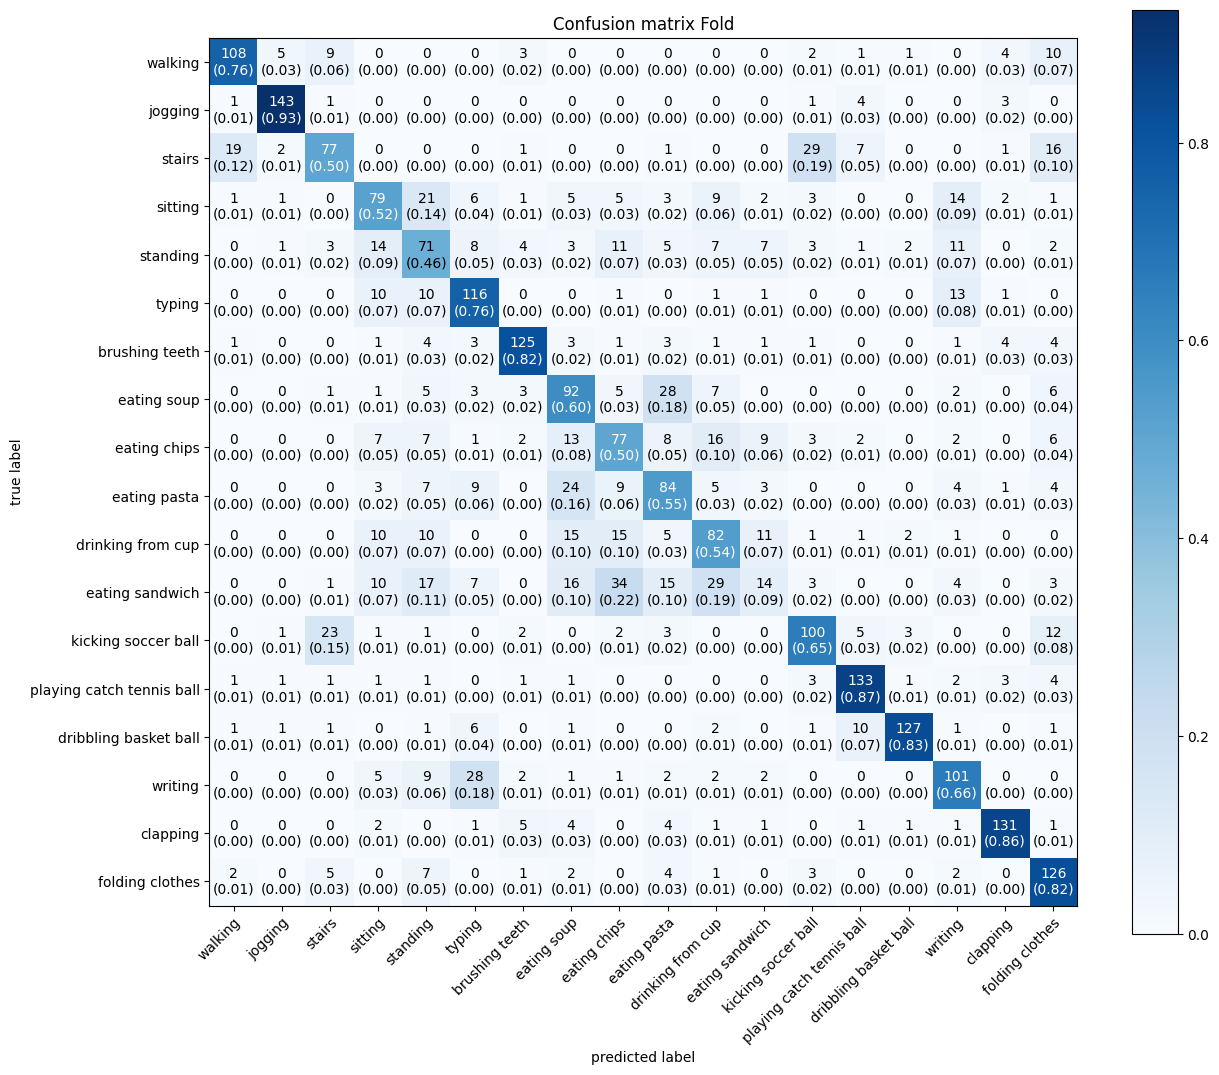

In [19]:
y_test_pred = lr_best_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
plotting.plot_confusion_matrix(conf_mat = conf_matrix,
                               class_names = ACTIVITY_NAMES,
                               show_normed = True,
                               figsize = (14, 12),
                               colorbar = True)
plt.title("Confusion matrix Fold")
plt.show()

#### Accuracy Per Activity

In [20]:
cm_act = pd.DataFrame(conf_matrix,
                      index=lr_best_classifier.classes_,
                      columns=lr_best_classifier.classes_)

cm_act.columns = ACTIVITY_CODES_MAP.values()
cm_act.index = ACTIVITY_CODES_MAP.values()
accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())
print(accuracy_per_activity)

                                  0
walking                    0.755245
jogging                    0.934641
stairs                     0.503268
sitting                    0.516340
standing                   0.464052
typing                     0.758170
brushing teeth             0.816993
eating soup                0.601307
eating chips               0.503268
eating pasta               0.549020
drinking from cup          0.535948
eating sandwich            0.091503
kicking soccer ball        0.653595
playing catch tennis ball  0.869281
dribbling basket ball      0.830065
writing                    0.660131
clapping                   0.856209
folding clothes            0.823529


/tmp/ipykernel_2398630/2628092090.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())


#### Classification Report

In [21]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred))
print("######################################################################################")

              precision    recall  f1-score   support

           A       0.81      0.76      0.78       143
           B       0.92      0.93      0.93       153
           C       0.63      0.50      0.56       153
           D       0.55      0.52      0.53       153
           E       0.42      0.46      0.44       153
           F       0.62      0.76      0.68       153
           G       0.83      0.82      0.83       153
           H       0.51      0.60      0.55       153
           I       0.48      0.50      0.49       153
           J       0.51      0.55      0.53       153
           K       0.50      0.54      0.52       153
           L       0.27      0.09      0.14       153
           M       0.65      0.65      0.65       153
           O       0.81      0.87      0.84       153
           P       0.93      0.83      0.88       153
           Q       0.64      0.66      0.65       153
           R       0.87      0.86      0.86       153
           S       0.64    

#### Test Accuracy

In [22]:
print("test accuracy", 100 * accuracy_score(y_true=y_test, y_pred=y_test_pred))

test accuracy 65.0874635568513
